**Imports**

Data

In [263]:
import pandas as pd
import os
print(os.getcwd())
current_folder = os.getcwd()
datasetFolder = 'Toys_and_Games' #CDs_and_Vinyl #Grocery_and_Gourmet_Food

# Open and load json training files
x = pd.read_json(os.path.join(current_folder, datasetFolder, 'train', 'review_training.json'))
y = pd.read_json(os.path.join(current_folder, datasetFolder, 'train', 'product_training.json'))

c:\Users\zachg\Documents\Programming\School\cs349_ML\test\amazonawesomeness


Other

In [397]:
import numpy as np
from nltk import sentiment
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import cross_validate
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')
from sklearn.model_selection import train_test_split

PATCH TO SPEED UP (ONLY IF INTEL CHIP) 

In [201]:
from sklearnex import patch_sklearn 

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
x #770786 rows <- # reviews
y #073082 rows <- # products

# Feature creation 

Making a sample set to test features:

In [ ]:
#ts = test sample 2 thousand reviews long
ts = x[:2000]
ts

Review Count

In [264]:
dropUnverified = x[x.verified == True]
reviewCount = x.groupby('asin')["reviewerID"].count()
reviewCount = reviewCount.rename("Review_Count")

In [ ]:
dropUnverified.groupby('asin')['unixReviewTime'].mean() #63401 rows! -> some products don't have ANY verified reviews

Percent verified

In [265]:
percent_verified = dropUnverified.groupby("asin")["reviewerID"].count()
percent_verified = percent_verified/reviewCount
percent_verified = percent_verified.apply(lambda x: x if x > 0  else 0)
percent_verified = percent_verified.rename("%_Verified")

Dropping bots by time of post

All the comments are encoded with the date only, no time, so this is not possible

In [ ]:
droppedBots = x[x.unixReviewTime % 100 != 0]

Total number of votes across reviews

In [266]:
x_copy = x.copy(deep=True)
total_review_num = x_copy.vote
total_review_num = total_review_num.apply(lambda x: float(x.replace(",", "")) if type(x) == str  else 0)
total_review_num #= total_review_num.rename("vote").to_frame()
# x_copy["vote"] = total_review_num["vote"]
# total_votes = x_copy.groupby('asin')["vote"].sum("vote")
# total_votes = total_votes.rename("Total_Votes")

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
640558    2.0
640559    0.0
640560    0.0
640561    0.0
640562    0.0
Name: vote, Length: 640563, dtype: float64

Percent of reviews with images

In [267]:
with_image = x[x.image.astype('string') != "None"]
with_image = with_image.groupby('asin')["image"].count()
with_image_percentage = with_image/reviewCount
with_image_percentage = with_image_percentage.apply(lambda x: x if x > 0  else 0)
#with_image_percentage = with_image_percentage[with_image_percentage > 0] # - to see how many reviews have at least one image
with_image_percentage = with_image_percentage.rename("%_Image")

# Helper Functions

clean up the vote type

In [233]:
def clean_type(z):
    if type(z) == str:
        return float(z.replace(",", ""))   
    elif type(z) == float:
        return z 
    else:
        return 0

vote weight

In [401]:
def votew(vote):
    if vote > 5 and vote < 20:
        return 0.6
    elif vote > 20:
        return 1
    return 0.3

image weight

In [402]:
def imagew(image):
    if image == None or image == 'None':
        return 0.3
    return 1

adding new things to x

In [403]:
x['vote'] = x['vote'].apply(lambda x: clean_type(x))
x['vote_weight'] = x['vote'].apply(lambda x: votew(x))
x['image_weight'] = x['image'].apply(lambda x: imagew(x))
# x

# Text Analysis

Small group to test text analyses

In [ ]:
testdata = x.groupby("asin").get_group("0000B049F5B33CD310EB1AB236E20191")

# np.mean(len(str(testdata["reviewText"]).split()))

Length of Reviews Feature

In [269]:
reviewlength = x.groupby('asin')["reviewText"].apply(lambda x: x.str.split().str.len().mean())
reviewlength = reviewlength.fillna(0).rename("Review_Length")

summarylength = x.groupby('asin')["summary"].apply(lambda x: x.str.split().str.len().mean())
summarylength = summarylength.fillna(0).rename("Summary_Length")


In [ ]:
# a= 1

# def f(votes):
#     if (votes>a):
#         return 2
#     return 344

In [ ]:
# x=x[:200]
# sia = sentiment.SentimentIntensityAnalyzer()
# RSentiment = x["reviewText"].apply(lambda x: sia.polarity_scores(x.to_string())["compound"]) #sentiment per no avg
# RSentiment = RSentiment.fillna(0).rename("Review_sentiment") #make that col
# #apply f(votes) to each element
# #avg the result



Percentage Uppercase Feature:

In [270]:
# def count_cap(str):
#     stripped = ''.join(str.split())
#     return sum(c.isupper() for c in ''.join(stripped))/len(stripped)

RpercentCap = x.groupby('asin')["reviewText"].apply(lambda x: (x.str.count("[A-Z]")/x.str.len()).mean())
RpercentCap = RpercentCap.fillna(0).rename("Review_Percent_Uppercase")

SpercentCap = x.groupby('asin')["summary"].apply(lambda x: (x.str.count("[A-Z]")/x.str.len()).mean())
SpercentCap = SpercentCap.fillna(0).rename("Summary_Percent_Uppercase")


Actual Awesomeness Feature: # times the word "awesome" is used per review

In [ ]:
actualAwesomeness = x.groupby('asin')["reviewText"].apply(lambda x: (x.str.count("[Aa]wesome")).mean())
actualAwesomeness = actualAwesomeness.fillna(0).rename("Actual_Awesomeness")

In [ ]:
actualAwesomeness

# Sentiment Analysis

downloads

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

In [504]:
import re

## Helper function for sentiment analysis testing
def review_sentiment(text):
    sia = sentiment.SentimentIntensityAnalyzer()
    return sia.polarity_scores(text)["compound"]

## just some examples to gut check
print(review_sentiment("LOVE BEST AWESOME !!!"))
print(review_sentiment("TERRIBLE DISGUSTING AWFUL !!!"))
print(review_sentiment("!"))

import string
def preprocess(text):
    if (text == None): return ""
    lemmatizer = WordNetLemmatizer()
    # text = re.split("[?.!] ",text)
    # text = "".join([char for char in text.lower() if char not in string.punctuation])
    words = [word for word in word_tokenize(text) if word not in stopwords.words("english")]
    tokens = [lemmatizer.lemmatize(token) for token in words]
    return " ".join(tokens)

0.9557
-0.927
0.0


preprocess, save to external file

In [505]:
x["processedTest"] = x["reviewText"].apply(preprocess)
x["processedTest"].to_json("../processedReviewsFOOD.json")
x["processedSums"] = x["summary"].apply(preprocess)
x["processedSums"].to_json("../processedSummaryFOOD.json")

Read from the jsons

In [417]:
revtext = pd.read_json("../processedReviewsFood.json",typ='series')
revtext.to_frame('processedText')
x["processedText"] = revtext.fillna("")

sumtext = pd.read_json("../processedSummaryFood.json",typ='series')
sumtext.to_frame('processedSums')
x["processedSums"] = sumtext.fillna("")

Getting concatenated corpus of all reviewTexts for each product

In [ ]:
x["concatReviews"] = x.groupby(['asin'],as_index=False).agg({'processedText': ' '.join})['processedText']
x["concatSums"] = x.groupby(['asin'],as_index=False).agg({'processedSums': ' '.join})['processedSums']

In [ ]:

q = x[["asin","concatReviews","concatSums"]]
q=q.dropna()
# q=q.to_frame()
q

#replace x with q, processedText with concatReviews, and processedSums with concatSums in the cell below 
# to get sentiment analysis of concatenated corpuses

##### Replace words related to # of stars with actual value so sentiment analysis can pick up on them

Manual replacement

In [295]:
def starReplacer(text):
    t= text.lower() 
    if ("five star" in t):
        return text + " excellent"
    elif ("four star" in t):
        return text + " okay"
    elif ("three star" in t):
        return text + " terrible"
    elif ("two star" in t):
        return text + " terrible"
    elif ("one star" in t):
        return text + " terrible"
    else: return text

In [296]:
x["processedSums"] = x["processedSums"].apply(lambda x: starReplacer(x))

Bag of Words word replacement

- the idea is to split the data into reviews for an AWESOME product and NOT AWESOME product, and find the words most common (and unique) to each
- then replace those words in all reviews with things like "AMAZING, LOVED IT, MASTERPIECE" if awesome or "TERRIBLE, AWFUL, DISGUSTING" if not so that the sentiment analysis will pick up on the awesomeness based on reviews better!
- try this with different n-grams to try to pick up on things like "five stars" or "couldn't stop eating"

In [412]:
#split data into pos, neg reviews
data_w_awesomeness = x.merge(y,"inner","asin")
pos_revs = data_w_awesomeness.query("awesomeness==1")
neg_revs = data_w_awesomeness.query("awesomeness==0")

In [411]:
def replaceWords(text, pos_words, neg_words):
    pos_message = "love best awesome"
    neg_message = "terrible disgusting awful"

    #replace
    for pw in pos_words:
        text = text.replace(" "+pw," "+pos_message)
    for nw in neg_words:
        text = text.replace(" "+nw," "+neg_message)

#spaces added to prevent replacing parts of words. 
# Still could replace ends of words, but probs not that much of an issue

    #append
    # for pw in pos_words:
    #     if (" "+pw) in text: text += " "+pos_message 
    # for nw in neg_words:
    #     if (" "+nw) in text: text += " "+neg_message 

    return text

def get_disjoint_elements(arr1,arr2):
    return [[e for e in arr1 if e not in arr2],[e for e in arr2 if e not in arr1]]

In [423]:
from sklearn.feature_extraction.text import CountVectorizer

#use count vectorizer on all reviews, summaries

def count_and_getMostCommon(textdf):
    cv = CountVectorizer(ngram_range=(1,2), max_features=50) #max_features itself gets most common, but not sorted
    #sum the resulting sparse matrices to get total counts
    counts = cv.fit_transform(textdf).toarray().sum(axis=0)
    #argsort to order by MOST COMMON 
    return cv.get_feature_names_out()[np.argsort(counts)[::-1]]

#get the words corresponding to the indexes
# put them into an array of pos_words, neg_words
rpos_words = count_and_getMostCommon(pos_revs["processedText"])
rneg_words = count_and_getMostCommon(neg_revs["processedText"])
spos_words = count_and_getMostCommon(pos_revs["processedSums"])
sneg_words = count_and_getMostCommon(neg_revs["processedSums"])

print("Review positive words: "+", ".join(rpos_words))
print("Review negative words: "+", ".join(rneg_words))

print("Summary positive words: "+", ".join(spos_words))
print("Summary negative words: "+", ".join(sneg_words))


#remove common words

[rpos_words,rneg_words] = get_disjoint_elements(rpos_words,rneg_words)
[spos_words,sneg_words] = get_disjoint_elements(spos_words,sneg_words)

print("UNIQUE Review positive words: "+", ".join(rpos_words))
print("UNIQUE Review negative words: "+", ".join(rneg_words))

print("UNIQUE Summary positive words: "+", ".join(spos_words))
print("UNIQUE Summary negative words: "+", ".join(sneg_words))


#could also try getting most common words and just deleting them ?

Review positive words: loved, amazing, masterpiece, amazing loved, it, loved it, it masterpiece, terrible, awful, disgusting, awful disgusting, terrible awful, awesome, masterpiece awesome, trash, disgusting trash, good, great, taste, like, love, flavor, tea, product, one, use, make, coffee, price, time, really, get, best, buy, much, would, delicious, dont, bag, sugar, also, chocolate, little, well, better, ive, brand, im, favorite, used
Review negative words: awful, terrible, disgusting, terrible awful, awful disgusting, trash, disgusting trash, loved, amazing, masterpiece, amazing loved, it masterpiece, loved it, it, awesome, masterpiece awesome, taste, good, like, flavor, great, coffee, love, one, product, tea, make, really, would, get, use, dont, much, time, buy, price, little, sugar, better, im, also, bag, chocolate, best, delicious, well, ive, sweet, tried, brand
Summary positive words: star, five, five star, amazing, loved, great, masterpiece, amazing loved, it masterpiece, love

In [425]:
# replace every use of the words in x sums/reviews by running replaceWords(text, pos_words, neg_words)
x["processedSums"] = x["processedSums"].apply(lambda text: replaceWords(text, spos_words, sneg_words))
x["processedText"] = x["processedText"].apply(lambda text: replaceWords(text, rpos_words, rneg_words))

TFIDF word replacement

- similar to bag of words replacement, but now for most IMPORTANT and nonoverlapping words instead of just most common

In [422]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_train_and_getfeatures(textdf):
    tfidf = TfidfVectorizer(max_features=50)
    tfidf.fit_transform(textdf)
    return tfidf.get_feature_names_out()

#fit tfidf to all reviews, summaries
#get_features_out (? or _vocab? or smth?) to get the words corresponding to #?# most important UNIQUE words
# put them into an array of words

rpos_words = tfidf_train_and_getfeatures(pos_revs["processedText"])
rneg_words = tfidf_train_and_getfeatures(neg_revs["processedText"])
spos_words = tfidf_train_and_getfeatures(pos_revs["processedSums"])
sneg_words = tfidf_train_and_getfeatures(neg_revs["processedSums"])

print("Review positive words: "+", ".join(rpos_words))
print("Review negative words: "+", ".join(rneg_words))

print("Summary positive words: "+", ".join(spos_words))
print("Summary negative words: "+", ".join(sneg_words))

#remove common words

[rpos_words,rneg_words] = get_disjoint_elements(rpos_words,rneg_words)
[spos_words,sneg_words] = get_disjoint_elements(spos_words,sneg_words)

print("UNIQUE Review positive words: "+", ".join(rpos_words))
print("UNIQUE Review negative words: "+", ".join(rneg_words))

print("UNIQUE Summary positive words: "+", ".join(spos_words))
print("UNIQUE Summary negative words: "+", ".join(sneg_words))

#could also try getting most common words and just deleting them ?

Review positive words: add, also, amazing, awesome, awful, bag, best, better, brand, buy, chocolate, coffee, delicious, disgusting, dont, even, favorite, find, flavor, get, go, good, great, im, it, ive, like, little, love, loved, make, masterpiece, much, nice, one, price, product, really, sugar, sweet, taste, tea, terrible, time, trash, tried, use, used, well, would
Review negative words: add, also, amazing, awesome, awful, bag, best, better, brand, buy, chocolate, coffee, delicious, disgusting, dont, eat, even, favorite, find, flavor, get, good, great, im, it, ive, like, little, love, loved, make, masterpiece, much, nice, one, price, product, really, sugar, sweet, taste, tea, terrible, time, trash, tried, use, used, well, would
Summary positive words: amazing, awesome, awful, best, better, buy, chocolate, coffee, delicious, disgusting, easy, ever, excellent, favorite, five, flavor, four, free, fresh, good, great, healthy, it, like, love, loved, make, masterpiece, nice, one, perfect, p

In [361]:
# replace every use of the words in x sums/reviews by running replaceWords(text, pos_words, neg_words)
x["processedSums"] = x["processedSums"].apply(lambda text: replaceWords(text, spos_words, sneg_words))
x["processedText"] = x["processedText"].apply(lambda text: replaceWords(text, rpos_words, rneg_words))

##### Apply sentiment analysis to data

In [418]:
sia = sentiment.SentimentIntensityAnalyzer()
x["rsent"] = x["processedText"].apply(lambda y: np.mean(sia.polarity_scores(y)["compound"]))
# x.loc[:, ["rsent"]] = x.loc[:,['rsent']].multiply(x.loc[:, 'vote_weight'], axis="index")
# x.loc[:, ["rsent"]] = x.loc[:,['rsent']].multiply(x.loc[:, 'image_weight'], axis="index")
RavgSentiment = x.groupby("asin")["rsent"].mean()
RavgSentiment = RavgSentiment.rename("Review_Avg_Sentiment")

x['sumsent'] = x["processedSums"].apply(lambda y: np.mean(sia.polarity_scores(y)["compound"]))
# x.loc[:, ["sumsent"]] = x.loc[:,['sumsent']].multiply(x.loc[:, 'vote_weight'], axis="index")
# x.loc[:, ["sumsent"]] = x.loc[:,['sumsent']].multiply(x.loc[:, 'image_weight'], axis="index")
SavgSentiment = x.groupby("asin")["sumsent"].mean()
SavgSentiment = SavgSentiment.rename("Summary_Avg_Sentiment")


In [ ]:
# sia = sentiment.SentimentIntensityAnalyzer()
# ts["sumsent"] = ts["processedSums"].apply(lambda x: sia.polarity_scores(x)["compound"])
# ts.loc[:, ["sumsent"]] = ts.loc[:,['sumsent']].multiply(ts.loc[:, 'vote_weight'], axis="index")
# ts.loc[:, ["sumsent"]] = ts.loc[:,['sumsent']].multiply(ts.loc[:, 'image_weight'], axis="index")
# t = ts.groupby('asin').mean()['sumsent']
# t
#ts.groupby("asin").mean()["sumsent"]
# Rtest = Rtest.rename("Review_Avg_Sentiment")

# Stest = x.groupby('asin')["processedSums"].fillna("").apply(lambda x: np.mean(sia.polarity_scores(x)["compound"]))
# Stest = Stest.rename("Summary_Avg_Sentiment")

# tfidf feature vector

In [ ]:
# tfidf for reviews

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(vocabulary=np.concatenate(rpos_words,rneg_words))
# 
# x["processedText"] = revtext
tfidf_DF = x[["asin","processedText"]]



# tfidf_DF["processedText"] = 
# tfidf_DF["processedTest"] = tfidf_DF["processedTest"].fillna("")
# tfidf_DF["processedRevs"] = tfidf_DF["reviewText"].fillna("").apply(preprocess)

tfidf.fit_transform(tfidf_DF["processedText"])
# tfidffeatures.toarray()
feature_names = tfidf.get_feature_names_out()

tfidf2 = TfidfVectorizer(vocabulary=tfidf.vocabulary_)
tfidfarray = tfidf2.fit_transform(tfidf_DF["processedText"]).toarray()

featuredf = pd.DataFrame(tfidfarray,columns = feature_names)
tfidf_DF = pd.concat([tfidf_DF,featuredf],axis=1)
RtfidfFeature = tfidf_DF.groupby("asin")[feature_names].mean()

RtfidfFeature

In [426]:
# tfidf for summary

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(vocabulary=np.concatenate(spos_words,sneg_words))
# 
# x["processedText"] = revtext
tfidf_DF = x[["asin","processedSums"]]



# tfidf_DF["processedText"] = 
# tfidf_DF["processedTest"] = tfidf_DF["processedTest"].fillna("")
# tfidf_DF["processedRevs"] = tfidf_DF["reviewText"].fillna("").apply(preprocess)

tfidf.fit_transform(tfidf_DF["processedSums"])
# tfidffeatures.toarray()
feature_names = tfidf.get_feature_names_out()

tfidf2 = TfidfVectorizer(vocabulary=tfidf.vocabulary_)
tfidfarray = tfidf2.fit_transform(tfidf_DF["processedSums"]).toarray()

featuredf = pd.DataFrame(tfidfarray,columns = feature_names)
tfidf_DF = pd.concat([tfidf_DF,featuredf],axis=1)
StfidfFeature = tfidf_DF.groupby("asin")[feature_names].mean()

StfidfFeature


,best,flavor,good,great,like,love,one,product,taste,tea
asin,,,,,,,,,,
00004C1575E00FDAB2DF85DA99F0891E,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
000056B2BB04C27DBA74979B4DBCC516,0.104386,0.167539,0.288169,0.179331,0.095769,0.333333,0.224654,0.000000,0.091727,0.000000
000069AC93D31A15BC5707FCA696C52C,0.138188,0.000000,0.000000,0.000000,0.507123,0.115571,0.148700,0.000000,0.364289,0.000000
000147A59EA421EE494EA6CD56CA25ED,0.000000,0.046795,0.097886,0.041817,0.103169,0.000000,0.000000,0.000000,0.331200,0.000000
00017A51C0C1C48D832D4F91B9309D81,0.046173,0.340831,0.250000,0.179015,0.084723,0.077233,0.049686,0.109714,0.172713,0.372605
...,...,...,...,...,...,...,...,...,...,...
FFF6F20B63DF25745DF400A0CEDD1DD6,0.000000,0.153055,0.000000,0.158036,0.396084,0.133168,0.000000,0.193713,0.000000,0.000000
FFFAAE22940D23D6658C88F3B2C3D090,0.064393,0.299048,0.159877,0.175560,0.154846,0.151965,0.153157,0.029574,0.140320,0.000000
FFFC86C6682DF835CC048EFD41E7D093,0.166667,0.083333,0.134795,0.083333,0.000000,0.000000,0.000000,0.065545,0.000000,0.000000


In [ ]:
tfidf max features 5 on good
5 on bad
-> enter that as new vocab

# Testing prep

Feature vectors must have format: col 1 as 'asin'

Currently using features:

Name                    |     Column Name

reviewCount                    Review_Count

~~with_image_percentage          %_Image~~

percent_verified               %_Verified

total_votes                    Total_Votes

reviewlength                   Review_Length

summarylength                  Summary_Length

RpercentCap                    Review_%_Uppercase

SpercentCap                    Summary_%_Uppercase

~~actualAwesomeness              Actual_Awesomeness~~

RavgSentiment                  Review_Avg_Sentiment

SavgSentiment                  Summary_Avg_Sentiment

In [415]:
#combine all individual features into one dataFrame

#enter any features to be combined here! 
#   They must be pd dataFrames with the 'asin' column for this to work
features = [RavgSentiment,SavgSentiment,RpercentCap,SpercentCap,reviewlength,summarylength,reviewCount]

z = x['asin']
for f in features:
    z = pd.merge(z,f,'inner','asin')

# add tfidf feature
for i in range(tfidfFeature.shape[1]):
    z = pd.merge(z,tfidfFeature[feature_names[i]],'inner','asin')



#combine resultant data with correct answers 
temp = pd.merge(z,y,'inner','asin') 
temp = temp.groupby("asin").mean()


#split into features (x) and awesomeness (y)
merged_x = temp.drop(['awesomeness'], axis=1)
merged_y = temp["awesomeness"]

# Looking At Features

In [378]:
temp.sort_values("awesomeness")

,Review_Avg_Sentiment,Summary_Avg_Sentiment,Review_Percent_Uppercase,Summary_Percent_Uppercase,Review_Length,Summary_Length,Review_Count,amazing,awesome,awful,disgusting,good,it,loved,masterpiece,terrible,trash,awesomeness
asin,,,,,,,,,,,,,,,,,,
00004C1575E00FDAB2DF85DA99F0891E,0.006376,0.004404,0.090514,0.121212,36.666667,2.333333,3.0,0.000000,0.000000,0.192341,0.192701,0.000000,0.000000,0.333333,0.000000,0.192308,0.000000,0.0
6BE7DDB9BEA83215AC2DA2CA8E31B1A5,0.017097,0.015759,0.036432,0.081872,40.200000,4.000000,5.0,0.170631,0.091407,0.178500,0.178833,0.083073,0.089754,0.087910,0.089750,0.178468,0.188517,0.0
CB6143D1942C4F1905523ACEC25CC137,0.104338,-0.052812,0.023095,0.050274,109.625000,5.687500,16.0,0.055427,0.064586,0.197160,0.197529,0.330777,0.056308,0.055151,0.056305,0.197126,0.192422,0.0
6BE129E00E63A3DE0BE94FFA65E1A0B2,0.013592,0.015476,0.045314,0.088699,15.500000,3.000000,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
6BDB77F7B26916C7271C486486EA00E4,0.105046,0.038617,0.021973,0.114394,140.250000,3.500000,4.0,0.078928,0.081659,0.199878,0.200252,0.079688,0.080182,0.078535,0.080179,0.199843,0.211095,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7314256DFEF05C6332E33CE0888B1B13,0.016280,0.009870,0.021988,0.015625,17.500000,2.500000,2.0,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
731106ACFB37A1ACCCC56CE5547C6B8E,0.052528,0.026099,0.050342,0.169489,14.666667,1.666667,9.0,0.111111,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
730F7191CC547134CA435DD22D3CE2A8,-0.042965,0.100890,0.027758,0.092999,25.750000,4.500000,4.0,0.000000,0.063434,0.387605,0.388329,0.000000,0.000000,0.127178,0.000000,0.387536,0.125840,1.0


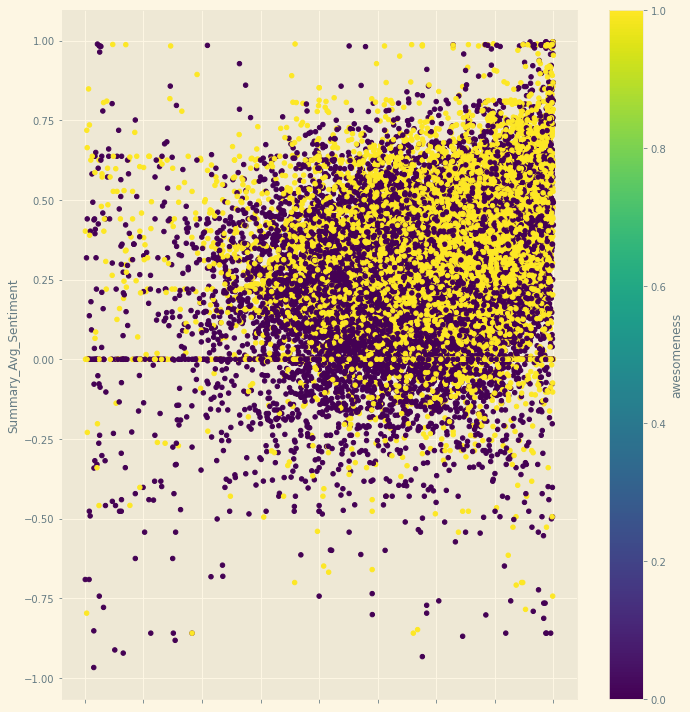

In [419]:
from pandas import plotting

# display a graph of Summary Sentiment vs Review Sentiment where color shows awesomeness.
# This should somewhat separate out datapoints of different awesomeness (there should be some correlation)

# import matplotlib.cm as cm
# import matplotlib.colormaps #<- not working I have no clue why
# cmap = matplotlib.colormaps['YlGn']
ax = temp.plot.scatter(x='Review_Avg_Sentiment', y='Summary_Avg_Sentiment',c='awesomeness')#,cmap = cmap)
# plt.xlim(-0.1,.2)
# plt.ylim(-.1,.2)
plt.show()

In [95]:
merged_x[:10]

,Review_Avg_Sentiment,Summary_Avg_Sentiment,Review_Percent_Uppercase,Summary_Percent_Uppercase,Review_Length,Summary_Length,Review_Count
asin,,,,,,,
00004C1575E00FDAB2DF85DA99F0891E,0.640333,0.222233,0.090514,0.121212,36.666667,2.333333,3.0
000056B2BB04C27DBA74979B4DBCC516,0.853533,0.585133,0.040913,0.117500,32.333333,5.333333,3.0
000069AC93D31A15BC5707FCA696C52C,0.947633,0.358933,0.052513,0.318239,217.333333,14.000000,3.0
000147A59EA421EE494EA6CD56CA25ED,0.096171,0.072729,0.049544,0.114688,12.571429,4.857143,7.0
00017A51C0C1C48D832D4F91B9309D81,0.813300,0.220075,0.029834,0.095148,61.500000,5.500000,4.0
0001914458A028F40D4B4DFCE2A135E3,0.671045,0.430336,0.048311,0.162315,14.181818,2.454545,11.0
00023FA16762C953E70F939F232A352C,0.298533,0.668400,0.064614,0.103324,5.666667,4.000000,3.0
000A58EFC2DCFB0F84BC517FFEFBBA4B,0.590327,0.376264,0.046021,0.157686,25.363636,4.545455,11.0
000AF123A46E5BC3F8A6508AB9886084,0.520667,0.436600,0.040363,0.154606,10.833333,2.777778,18.0


# Models

(choose one)

Support Vector Machine (SVM)

In [ ]:
from sklearn import svm

#kernel type
#‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
kernel = 'linear'

#if kernel type = 'poly', degree of poly
degree = 4

#whether to enable probability estimates (will slow it down a lot)
probability = False

#tau - penalty for errors is inversely proportional to C
C = 0.2

param_grid = [{'kernel': ['linear','poly','rbf','sigmoid'],
             'C': [0.25,0.5,0.75,1]}]

# param_grid = [{'kernel': ['poly','rbf','sigmoid'],
#             'C': [0.25,0.5,0.75,1]}]
# -> {'C': 0.75, 'kernel': 'poly'}
# f1: 0.694757392846268

# param_grid = [{'degree': [2,3,4,5],
#              'C': [0.7,0.75,0.8]}]
# -> {'C': 0.75, 'degree': 4}
# f1: 0.6805724352995487

svm_model = svm.SVC(C=C, kernel=kernel, degree=degree, probability=probability)

Linear SVC (linear svm, but scales better with large datasets)

In [331]:
from sklearn.svm import LinearSVC

#penalty norm calculation method
#"l1","l2"
penalty = "l2"

#loss function
#"hinge", "squared_hinge"
loss = "hinge"

#tolerance for stopping criteria
tol = 0.1

#tau - inversely proportional to C, error penalty
C = .5

# apply weights to classes inversely proportional to class frequency 
#   (balance for class freq in input data)
# dictionary, "balanced", or None
class_weight = None

#max-iterations
max_iter = 10000

# param_grid = [{'penalty': ['l1','l2'],
#                'loss': ['hinge','squared_hinge'],
#                'tol': [1e-4,1e-3,1e-2,1e-1,1],
#                'C': [0.25,0.5,0.75,1],
#                'class_weight': ['balanced',None],
#                'max_iter': [500,1000,2000]}]
# {'C': 0.5, 'class_weight': None, 'loss': 'hinge', 'max_iter': 2000, 'penalty': 'l2', 'tol': 0.1}
# 0.624863855609149

# param_grid = [{
#                'loss': ['hinge','squared_hinge'],
#                'tol': [1e-4,1e-3,1e-2,1e-1,1],
#                'C': [0.25,0.5,0.75,1],
#                'class_weight': ['balanced',None],
#                'max_iter': [500,1000,2000]}]


linearsvc_model = LinearSVC(penalty=penalty,loss=loss,tol=tol,C=C,class_weight=class_weight,max_iter=max_iter)

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier(early_stopping=True, n_jobs=-1)

# not sure if this is legal it has a perceptron option so is it ok???

Kernel approximation options (nonlinear transformations of input features)

In [420]:
from sklearn.kernel_approximation import RBFSampler #radial basis function kernel

rbfsampler = RBFSampler()

Basic Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

Decision Tree

In [ ]:
from sklearn import tree

#choose from 'entropy', 'gini', 'log_loss'
criterion = 'gini'

    ###STOPPING CONDITIONS
#max height/depth of the tree OR None if no limit
max_depth = 5

#if sat(N) < n_samples*this, don't try to split it any further
min_samples_split = .05

    ###OTHER
#if min(sat(nodes after a split)) < n_samples*this, split not considered 
#       (aka model isnt allowed to create leaf nodes with < n_samples*this samples)
#       (smooths the model, avoids splits like 2000 -> 1999 vs 1)
min_samples_leaf = 0.01

# param_grid = [{'criterion': ['entropy','gini','log_loss'],
#             'max_depth': [None,5,10,15,20],
#             'min_samples_split': [2,10,20,0.01,0.05,0.1,0.2],
#             'min_samples_leaf':[2,10,20,0.01,0.05,0.1,0.2]}]
# -> {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 0.01, 'min_samples_split': 0.05}
# f1: 0.6440347415923986

dtree_model = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

Decision Tree - See what it looks like! 

(only run if the model is a decision tree)

*note: this trains the model on the whole dataset, so don't do before testing!*

In [ ]:
dtree_model.fit(merged_x,merged_y)
tree.plot_tree(dtree_model)

K-Nearest Neighbors

In [177]:
from sklearn.neighbors import KNeighborsClassifier

#number of neighbors
n_neighbors = 7

#do you want proximity to effect influence neighbors have or not
# 'uniform' or 'distance'
weights='distance'

#leaf size passed to trees
leaf_size=3

# param_grid = [{'n_neighbors': [5,7,9,11],
#             'weights': ['uniform','distance'],
#             'leaf_size':[15,20,25,30]}] -> f1: 0.67, {'leaf_size': 15, 'n_neighbors': 11, 'weights': 'uniform'}

# param_grid = [{'n_neighbors': [9,11,15,19,23],
#              'weights': ['uniform','distance'],
#              'leaf_size':[5,10,15,20]}] -> f1: 0.65, {'leaf_size': 5, 'n_neighbors': 23, 'weights': 'uniform'}

# param_grid = [{'n_neighbors': [11,22,33,44,55],
#              'weights': ['uniform','distance'],
#              'leaf_size':[1,2,3,4,5,6,7,8,9,10,11,12]}] 
# -> {'leaf_size': 1, 'n_neighbors': 55, 'weights': 'uniform'}
# f1: 0.63

# param_grid = [{'n_neighbors': [11,22,33,44,55],
#              'weights': ['uniform','distance'],
#              'leaf_size':[1,2,3,4,5,6,7,8,9,10,11,12]}]
# -> {'leaf_size': 3, 'n_neighbors': 55, 'weights': 'distance'}
# f1: 0.6115

# param_grid = [{'n_neighbors': [1000,1500,2000,2500]}]
# -> {'n_neighbors': 2500}

knn_model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, leaf_size=leaf_size, n_jobs=-1)

Logistic Regression

In [176]:
from sklearn.linear_model import LogisticRegression

#norm of the penalty
#‘l1’, ‘l2’, ‘elasticnet’, None
penalty = 'l2'

#inverse of regulation strength tau - how much do errors cost?
C = 0.35

#algorithm to compute optimization problem. Probs wont do much other than speed
#‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’
solver = 'sag'

max_iter=500

param_grid = [{'penalty': ['l1','l2','elasticnet',None],
            'C': [0.25,0.5,0.75,1],
            'solver': ['lbfgs','newton-cg','newton-cholesky','sag','saga'],
            'max_iter': [1000,500,100]}]        
# -> {'C': 0.5, 'max_iter': 500, 'penalty': 'l2', 'solver': 'sag'}
# f1: 0.6916044272473679

# param_grid = [{'C': [0.4,0.45,0.5,0.55,0.6],
#             'solver': ['lbfgs','newton-cg','newton-cholesky','sag','saga'],
#             'max_iter': [700,600,500,400,300]}]
# -> {'C': 0.4, 'max_iter': 500, 'solver': 'sag'}
# f1: 0.6915982039214981

# param_grid = [{'C': [0.3,0.35,0.4,0.45]}]
# -> {'C': 0.35}
# f1: 0.6915982039214981

regression_model = LogisticRegression(penalty=penalty, C=C, solver=solver, max_iter=max_iter, n_jobs=-1)

Try nonlinear regression by manipulating given features:

In [ ]:
#to nonlinearly transform features!
#np.sqrt, np.log, np.square
f = np.sqrt

merged_x = merged_x.apply(lambda x: f(x+1))

Random Forest

In [126]:
from sklearn.ensemble import RandomForestClassifier

#number of trees, int
n_estimators=50

#Criteria to determine split quality
#“gini”, “entropy”, “log_loss”
criterion = 'log_loss'

#max depth of each tree, int or None for infinite
max_depth = 10

#min #/% of samples to leave in a branch after a split
min_samples_split = 0.01

#min #/% of samples to be a leaf node
min_samples_leaf = 2

# param_grid = [{'n_estimators': [50,100,150],
#             'criterion': ['gini','entropy','log_loss'],
#             'max_depth':[None,10,15,20],
#             'min_samples_split':[2,0.01,0.05,0.1,0.2],
#             'min_samples_leaf':[2,0.01,0.05,0.1,0.2]}]
# {'criterion': 'log_loss', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 0.01, 'n_estimators': 50}
# 0.660806071960417

param_grid = [{'n_estimators': [30,40,50,60],
            'max_depth':[8,9,10,11],
            'min_samples_split':[0.005,0.01,0.015],
            'min_samples_leaf':[2,7,10]}]
# {'max_depth': 9, 'min_samples_leaf': 10, 'min_samples_split': 0.005, 'n_estimators': 40}
# 0.6679347567644682

randomforest_model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, n_jobs=-1)

# Boosting!
make a model better! goes into *boosted_model*

AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

#model to build off of
#estimator = model

#max number of estimators to compute before terminating testing
n_estimators = 20

#weight applied to each classifier at each boosting iteration
learning_rate = 1.0

# param_grid = [{'n_estimators': [10,20,30],
#             'learning_rate': [1,2,3]}]

adaboosted_model = AdaBoostClassifier(estimator=regression_model, n_estimators=n_estimators, learning_rate=learning_rate)

Gradient Boosting

In [321]:
from sklearn.ensemble import HistGradientBoostingClassifier

#loss function to use in boosting process
#‘log_loss’, ‘auto’, ‘binary_crossentropy’/depreciated, ‘categorical_crossentropy’
loss = 'log_loss'

#shrinkage - multiplicative value for leaves
learning_rate=0.1

#maximum iterations for boosting process
max_iter=100

#maximum leaf nodes/tree
max_leaf_nodes=25

#max depth/tree or None for infinite
max_depth = None

#min samples to be a leaf
min_samples_leaf=20

#regularization parameter, 0 for none
l2_regularization=0.1

param_grid = [{'learning_rate': [0.1,0.3,0.5,0.7,1],
            'max_iter':[50,60],
            'max_leaf_nodes':[25,30,35,40],
            'max_depth':[None,10,15,20],
            'min_samples_leaf':[20,0.01,0.05,0.1,0.2],
            'l2_regularization':[0,0.1,0.2]}] 
# {'l2_regularization': 0.1, 'learning_rate': 0.1, 'max_depth': None, 'max_iter': 60, 'max_leaf_nodes': 25, 'min_samples_leaf': 20}
# 0.6629585231359386

gradient_boosted_model = HistGradientBoostingClassifier(loss=loss, learning_rate=learning_rate, max_iter=max_iter, max_leaf_nodes=max_leaf_nodes, max_depth=max_depth, min_samples_leaf=min_samples_leaf, l2_regularization=l2_regularization)

Bagging (for speed!)

In [ ]:
from sklearn.ensemble import BaggingClassifier

#number of estimators
n_estimators = 10

bagged_model = BaggingClassifier(svm_model, max_features=1/n_estimators, n_estimators=n_estimators, n_jobs=-1)

LATE FUSION

In [178]:
from sklearn.ensemble import StackingClassifier

#which models to use for primary predictions
estimators = [('forest',randomforest_model),('knn',knn_model),('svc',linearsvc_model)]

#which model to use for final prediction
final_estimator = svm_model

#k for cross validation for training of final_estimator
cv = 10

late_fused_model = StackingClassifier(estimators=estimators, final_estimator=final_estimator,cv=cv,n_jobs=-1)

Standard scaler pipeline

In [325]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('scaler', StandardScaler()), ('model', gradient_boosted_model)])

# Testing

Combined K-Fold Testing + Result Displaying

In [332]:
#desired metrics
scoring=['f1','accuracy','precision','recall']

#number of "folds"
k=10

cv_results = cross_validate(linearsvc_model, merged_x, merged_y, cv=k, scoring=scoring)


#print means, stdevs
hline = ("-"*40)
print(hline+"\n\tAVG, STDEV TEST RESULTS\n"+hline)
print("\t\tMEAN\t\tSTDEV")
for m in scoring:
        ind = ("test_"+m)
        test = (m+":").ljust(10)
        print(f"{test}\t{np.round(cv_results[ind].mean(),4)}\t\t{np.round(cv_results[ind].std(),4)}")

c:\Users\zachg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zachg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zachg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zachg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zachg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

----------------------------------------
	AVG, STDEV TEST RESULTS
----------------------------------------
		MEAN		STDEV
f1:       	0.6554		0.012
accuracy: 	0.6416		0.0101
precision:	0.6241		0.011
recall:   	0.6906		0.0253


c:\Users\zachg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


K-Fold testing

In [186]:
#desired metrics
scoring=['f1','accuracy','precision','recall']

#number of "folds"
k=10

cv_results = cross_validate(gradient_boosted_model, merged_x, merged_y, cv=k, scoring=scoring)

Pretty printing results

In [191]:
hline = ("-"*40)

#print means, stdevs
print(hline+"\n\tAVG, STDEV TEST RESULTS\n"+hline)
print("\t\tMEAN\t\tSTDEV")
for m in scoring:
        ind = ("test_"+m)
        test = (m+":").ljust(10)
        print(f"{test}\t{np.round(cv_results[ind].mean(),4)}\t\t{np.round(cv_results[ind].std(),4)}")


    ##print per test results (if you really want, uncomment)
# print("\n")
# print(hline+"\n\tPER TEST RESULTS\n"+hline)
# for i in range(k):
#     print(f"Test {i}:")
#     for m in scoring:
#         ind = ("test_"+m)
#         test = (m+":").ljust(10)
#         print(f"\t{test} {np.round(cv_results[ind][i],5)}")

----------------------------------------
	AVG, STDEV TEST RESULTS
----------------------------------------
		MEAN		STDEV
f1:       	0.6681		0.0094
accuracy: 	0.6392		0.0104
precision:	0.6121		0.0097
recall:   	0.7356		0.0148


# Grid Search

Testing Split

In [194]:
x_train, x_test, y_train, y_test = train_test_split(merged_x, merged_y, test_size=0.5, random_state=2)

Grid Searching for Best Parameters

must have parameters for variable in *param_grid*

In [196]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(gradient_boosted_model, param_grid=param_grid, scoring='f1', cv=10)
grid_search.fit(x_train,y_train)
print(grid_search.best_params_)
print(grid_search.score(x_test,y_test))

c:\Users\zachg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
19200 fits failed out of a total of 24000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4800 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\zachg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\zachg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py", line 353, in fit
    self._validate_params()
  File "c:\Users\zachg\AppData\Local\Programs\Python

{'l2_regularization': 0.1, 'learning_rate': 0.1, 'max_depth': None, 'max_iter': 60, 'max_leaf_nodes': 25, 'min_samples_leaf': 20}
0.6629585231359386


Halving random grid search (for speed up)

In [181]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

hg_search = HalvingGridSearchCV(pipeline, param_grid=param_grid, scoring='f1', cv=10)
hg_search.fit(x_train,y_train)
print(hg_search.best_params_)
print(hg_search.score(x_test,y_test))

ValueError: Invalid parameter 'C' for estimator Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 StackingClassifier(cv=10,
                                    estimators=[('forest',
                                                 RandomForestClassifier(criterion='log_loss',
                                                                        max_depth=10,
                                                                        min_samples_leaf=2,
                                                                        min_samples_split=0.01,
                                                                        n_estimators=50,
                                                                        n_jobs=-1)),
                                                ('knn',
                                                 KNeighborsClassifier(leaf_size=3,
                                                                      n_jobs=-1,
                                                                      n_neighbors=7,
                                                                      weights='distance')),
                                                ('svc',
                                                 LinearSVC(C=1, loss='hinge',
                                                           max_iter=10000))],
                                    final_estimator=SVC(C=0.2, degree=4,
                                                        kernel='linear'),
                                    n_jobs=-1))]). Valid parameters are: ['memory', 'steps', 'verbose'].

# Feature Selection

In [ ]:
from sklearn.feature_selection import RFECV

selector = RFECV(randomforest_model, step=1, cv=10) 
selector = selector.fit(merged_x,merged_y)
print(selector.support_)
print(selector.ranking_)
print(selector.feature_names_in_)

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2


print(merged_x.shape)
new_x = SelectKBest(chi2, k='all')
absx = merged_x.apply(lambda x: x+1) #selectKBest requires all positive values, sentiment analysis is between -1 and 1 -> 0 and 2 now!
out = new_x.fit_transform(absx, merged_y)
print(new_x.scores_)
print(new_x.feature_names_in_)
print(out.shape)

# SELECTKBEST: [3.25559172e+02 5.59255454e-03 2.75958219e+01 3.66946669e+02
#  3.42079412e+01 4.36649522e+01 1.85080492e+04 6.30872323e+01
#  7.68359033e-01 3.83305432e-01 1.04268202e-02]
# -['Review_Count' '%_Image' '%_Verified' 'Total_Votes'
#  'Review_Avg_Sentiment' 'Summary_Avg_Sentiment' 'Review_Length'
#  'Summary_Length' 'Summary_Percent_Uppercase' 'Review_Percent_Uppercase'
#  'Actual_Awesomeness']
#-> RFECV: [1 3 1 1 1 1 1 1 1 2]

# SO: 
# Seems like %_image, actual_awesomeness do the least. Percent_uppercases do the next worst.
# -> lets try cutting them out!

#->
# [  325.55917172    27.59582185   366.94666861    34.20794125
#     43.6649522  18508.04915683    63.08723227]
# ['Review_Count' '%_Verified' 'Total_Votes' 'Review_Avg_Sentiment'
#  'Summary_Avg_Sentiment' 'Review_Length' 'Summary_Length']
# -> RFECV2: [4 1 5 1 1 3 2]
#

# ROC Curve

c:\Users\zachg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


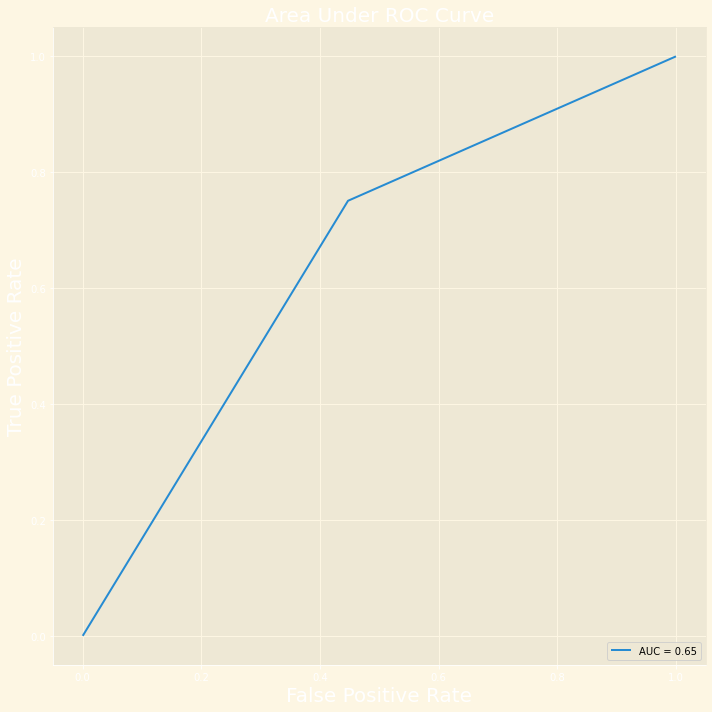

In [396]:
y_pred = linearsvc_model.fit(x_train, y_train).predict(x_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred)
AUROC = metrics.auc(fpr, tpr)

disp = metrics.RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=AUROC)



fig = plt.figure()
ax = fig.add_subplot()
ax.tick_params(axis='x', colors='white') 
ax.tick_params(axis='y', colors='white') 
ax.spines['left'].set_color('white') 
ax.spines['bottom'].set_color('white') 

plt.rcParams['figure.figsize'] = [10, 10]
plt.xlabel("X",fontsize=20, color='white')
plt.ylabel("Y",fontsize=20, color='white')
plt.title("Area Under ROC Curve", fontsize = 20, color='white')

disp.plot(ax)

plt.show()

# Getting Prediction for Test Data

Loading in test data

In [ ]:
x = pd.read_json('CDs_and_Vinyl/test1/review_test.json')
test_y = pd.read_json('CDs_and_Vinyl/test1/product_test.json')

Rerun Variable Analyses! then...

In [ ]:
#Again, combine all individual features into one dataFrame

features = [reviewCount,percent_verified,total_votes,RavgSentiment,SavgSentiment,reviewlength,summarylength,RpercentCap,SpercentCap]

test_merged_x = x['asin']
for f in features:
    test_merged_x = pd.merge(test_merged_x,f,'inner','asin')
test_merged_x = test_merged_x.groupby("asin").mean()

Make prediction

In [ ]:
# Make prediction
predictions = randomforest_model.predict(test_merged_x) 

# Rejoin to create output
test_y.insert(1, "predictions", predictions)

In [ ]:
test_y = pd.DataFrame(y_test)

Output predictions to file!

In [ ]:
# Output predictions to file!
  
#turn predictions into json
json_str = test_y.to_json()

#output json to file
with open('predictions.json', 'w') as f:
    f.write(json_str)